In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from vic.dataloader import (
    load_orl,
    load_yale,
    make_fixed_test_indices,
    split_with_fixed_test,
)
from vic.models import LBPH
import json
import cv2

In [3]:
orl = load_orl("../data/ORL")
yale = load_yale("../data/Yale")

test_idx_orl, pool_idx_orl = make_fixed_test_indices(orl, n_test=3, seed=0)
test_idx_yale, pool_idx_yale = make_fixed_test_indices(yale, n_test=3, seed=0)

Xtr_orl, ytr_orl, Xte_orl, yte_orl = split_with_fixed_test(
    orl, test_idx_orl, pool_idx_orl, 6, seed=0
)
Xtr_yale, ytr_yale, Xte_yale, yte_yale = split_with_fixed_test(
    yale, test_idx_yale, pool_idx_yale, 6, seed=0
)

In [4]:
def compute_acc_json(
    data, test_idx, pool_idx, Ps, Rs, n_train=7, seed=0, json_file="results.json"
):
    """
    Compute accuracy for each (P, R) combination with checkpointing to JSON.
    """
    # Load existing results if available
    try:
        with open(json_file, "r") as f:
            results = json.load(f)
    except FileNotFoundError:
        results = {}

    Xtr, ytr, Xte, yte = split_with_fixed_test(
        data, test_idx, pool_idx, n_train=n_train, seed=seed
    )

    total_combinations = len(Ps) * len(Rs)
    pbar = tqdm(total=total_combinations, desc="Evaluating P-R combinations")

    for P in Ps:
        for R in Rs:
            key = f"{P}-{R}"
            if key in results:
                pass  # skip already computed
            else:
                model = LBPH(P=P, R=R)
                model.fit(Xtr, ytr)
                y_pred = model.predict(Xte)
                acc = float(np.mean(y_pred == yte))
                results[key] = acc

                # Save immediately
                with open(json_file, "w") as f:
                    json.dump(results, f, indent=2)

            pbar.update(1)

    pbar.close()
    return results


def plot_acc_colormap(results, Ps, Rs, save_file="accuracy_colormap.png", title=""):
    """
    Plot 2D accuracy colormap (heatmap) scaled from 0 to 1.
    """
    accs = np.zeros((len(Ps), len(Rs)))
    for i, P in enumerate(Ps):
        for j, R in enumerate(Rs):
            key = f"{P}-{R}"
            accs[i, j] = results[key]

    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(accs, cmap="viridis", origin="lower", aspect="auto")

    ax.set_xlabel("R")
    ax.set_ylabel("P")

    ax.set_xticks(np.arange(len(Rs)))
    ax.set_xticklabels(Rs)
    ax.set_yticks(np.arange(len(Ps)))
    ax.set_yticklabels(Ps)
    ax.set_title(title)

    fig.colorbar(im, ax=ax, label="Accuracy")

    plt.tight_layout()
    plt.savefig(save_file, dpi=300)
    plt.show()


In [5]:
Ps = [2, 4, 8, 16]
Rs = [1, 2, 4, 8]

acc_orl = compute_acc_json(
    orl,
    test_idx_orl,
    pool_idx_orl,
    Ps,
    Rs,
    n_train=7,
    seed=0,
    json_file="../logs/LPBH_ORL_results.json",
)

acc_yale = compute_acc_json(
    yale,
    test_idx_yale,
    pool_idx_yale,
    Ps,
    Rs,
    n_train=7,
    seed=0,
    json_file="../logs/LPBH_Yale_results.json",
)

Evaluating P-R combinations: 100%|██████████| 16/16 [00:00<00:00, 573580.03it/s]


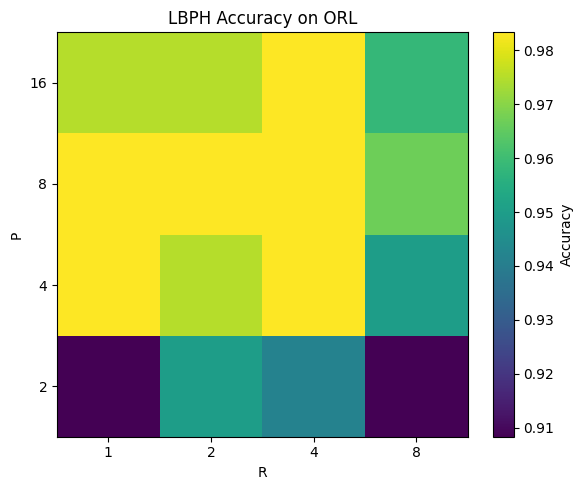

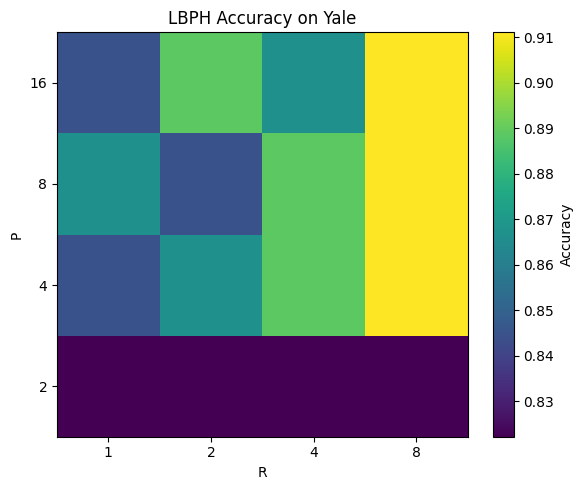

In [6]:
plot_acc_colormap(
    acc_orl,
    Ps,
    Rs,
    save_file="../figures/LPBH_ORL_accuracy_3d.png",
    title="LBPH Accuracy on ORL",
)

plot_acc_colormap(
    acc_yale,
    Ps,
    Rs,
    save_file="../figures/LPBH_Yale_accuracy_3d.png",
    title="LBPH Accuracy on Yale",
)

In [7]:
def identity(x):
    return x


def gaussian_blur(x, k=11):
    return cv2.GaussianBlur(x, (k, k), 0)


def jitter_and_sp(x, alpha=1.4, beta=30, p=0.05):
    # brightness / contrast jitter
    x2 = x.astype(np.float32) * alpha + beta
    x2 = np.clip(x2, 0, 255).astype(np.uint8)

    # salt & pepper
    mask = np.random.rand(*x.shape)
    x2[mask < p / 2] = 0
    x2[mask > 1 - p / 2] = 255
    return x2


def random_rotation(x, max_angle=20):
    angle = np.random.uniform(-max_angle, max_angle)
    h, w = x.shape
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    return cv2.warpAffine(x, M, (w, h), borderMode=cv2.BORDER_REFLECT)


def random_crop_resize(x, keep=0.75):
    if keep >= 1:
        return x
    h, w = x.shape
    ch, cw = int(h * keep), int(w * keep)

    y0 = np.random.randint(0, h - ch)
    x0 = np.random.randint(0, w - cw)

    crop = x[y0 : y0 + ch, x0 : x0 + cw]
    return cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)

In [8]:
P = 8
R = 2

blur_ks = [1, 3, 5, 9, 13]
noise_ps = [0.0, 0.02, 0.05, 0.10, 0.15]
rot_angles = [0, 5, 10, 15, 20, 30]
crop_keeps = [0.6, 0.7, 0.8, 0.9, 1]

In [9]:
def apply_effect(x, effect, param):
    if effect == "blur":
        if param == 1:  # no blur
            return x
        return cv2.GaussianBlur(x, (param, param), 0)
    elif effect == "noise":
        return jitter_and_sp(x, p=param)
    elif effect == "rotation":
        return random_rotation(x, max_angle=param)
    elif effect == "crop":
        return random_crop_resize(x, keep=param)
    else:
        raise ValueError(effect)


def run_experiment(data, test_idx, pool_idx, effect, params, runs=3, json_file=None):
    acc_all = []

    # Load existing results if available
    if json_file:
        try:
            with open(json_file, "r") as f:
                cached_results = json.load(f)
        except FileNotFoundError:
            cached_results = {}
    else:
        cached_results = {}

    for param in params:
        acc_runs = []
        for seed in range(runs):
            key = f"{effect}_{param}_{seed}"
            if key in cached_results:
                acc = cached_results[key]
            else:
                # Split the data first
                Xtr, ytr, Xte, yte = split_with_fixed_test(
                    data, test_idx, pool_idx, n_train=7, seed=seed
                )
                # Apply effect only to training set
                Xtr_aug = np.array([apply_effect(x, effect, param) for x in Xtr])
                # Train and evaluate
                model = LBPH(P=P, R=R)
                model.fit(Xtr_aug, ytr)
                y_pred = model.predict(Xte)
                acc = float(np.mean(y_pred == yte))

                # Save immediately
                if json_file:
                    cached_results[key] = acc
                    with open(json_file, "w") as f:
                        json.dump(cached_results, f, indent=2)

            acc_runs.append(acc)
        acc_all.append(acc_runs)
    acc_all = np.array(acc_all)
    mean = acc_all.mean(axis=1)
    std = acc_all.std(axis=1)
    return mean, std

Running experiments for Gaussian Blur.
Running experiments for Noise Magnitude.
Running experiments for Rotation Angle.
Running experiments for Random Crop.


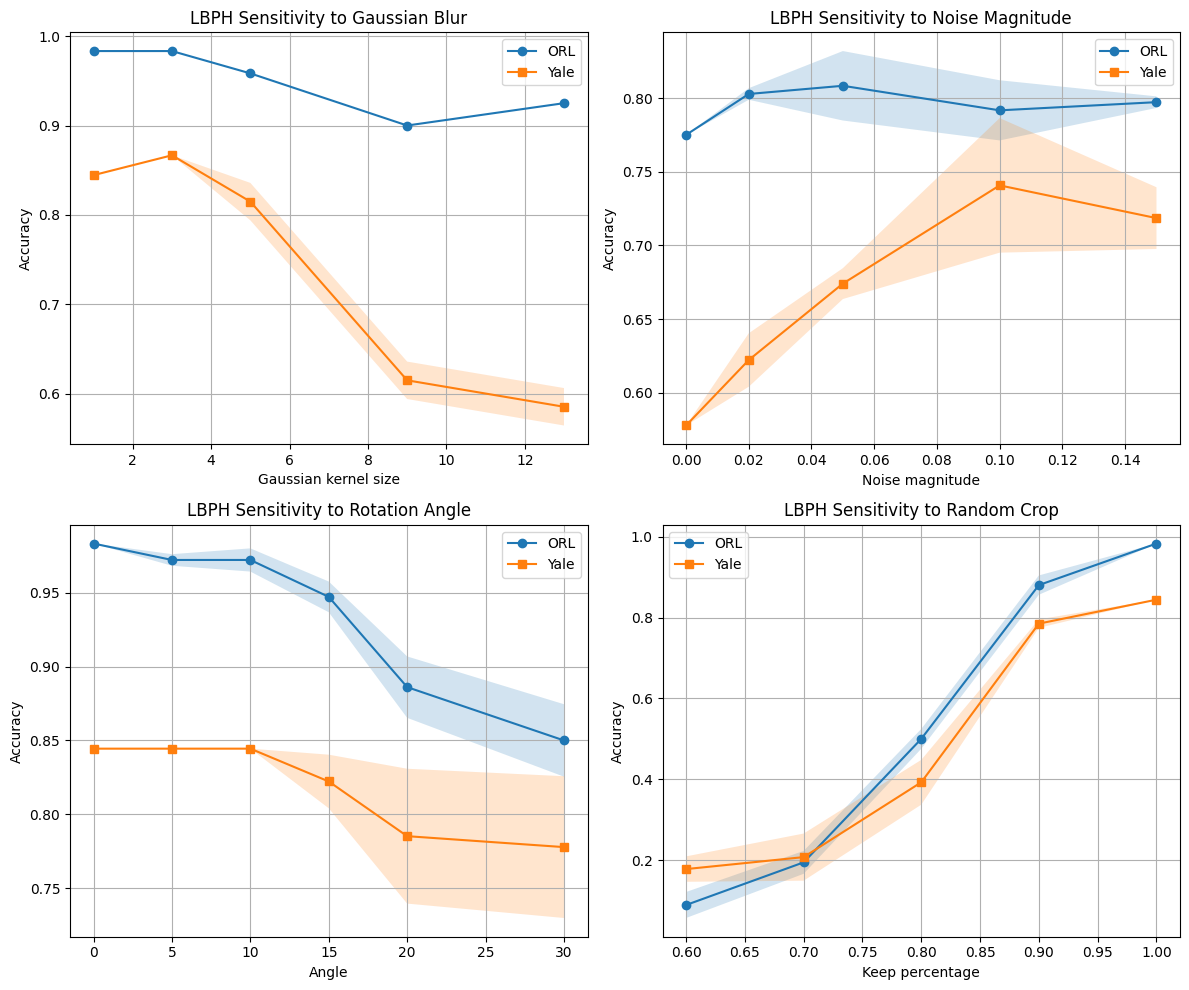

In [10]:
effects = {
    "blur": ("Gaussian Blur", blur_ks),
    "noise": ("Noise Magnitude", noise_ps),
    "rotation": ("Rotation Angle", rot_angles),
    "crop": ("Random Crop", crop_keeps),
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (effect_key, (effect_name, params)) in enumerate(effects.items()):
    print(f"Running experiments for {effect_name}.")
    ax = axes[i]
    # ORL
    mean_orl, std_orl = run_experiment(
        orl,
        test_idx_orl,
        pool_idx_orl,
        effect_key,
        params,
        json_file=f"../logs/LPBH_Robustness_ORL_{effect_key}.json",
    )
    ax.plot(params, mean_orl, label="ORL", marker="o")
    ax.fill_between(params, mean_orl - std_orl, mean_orl + std_orl, alpha=0.2)
    # Yale
    mean_yale, std_yale = run_experiment(
        yale,
        test_idx_yale,
        pool_idx_yale,
        effect_key,
        params,
        json_file=f"../logs/LPBH_Robustness_Yale_{effect_key}.json",
    )
    ax.plot(params, mean_yale, label="Yale", marker="s")
    ax.fill_between(params, mean_yale - std_yale, mean_yale + std_yale, alpha=0.2)

    ax.set_title(f"LBPH Sensitivity to {effect_name}")

    if effect_key == "rotation":
        ax.set_xlabel("Angle")
    elif effect_key == "blur":
        ax.set_xlabel("Gaussian kernel size")
    elif effect_key == "noise":
        ax.set_xlabel("Noise magnitude")
    elif effect_key == "crop":
        ax.set_xlabel("Keep percentage")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()


plt.tight_layout()
plt.savefig("../figures/LBPH_robustness.png", dpi=300)
plt.show()